# Database and library installation and setup

### Import libraries

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

from ast import literal_eval

### Functions

In [56]:
def dict_to_list(dict_str):
    """
    Parses a json dictionary into a list
    """
    try:
        genre_dict = literal_eval(dict_str)
        return list(genre_dict.values())
    except (ValueError, SyntaxError):
        return None
    
def str_to_list(str):
    """
    Parses a string which includes values seperated by commas and returns a list
    """
    try:
        return str.split(", ")
    except AttributeError:
        return None

### Database setup

In [72]:
PATH = 'cmu/'

movies = pd.read_csv(PATH + 'movie.metadata.tsv', sep='\t', header=None)
movies.columns = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres']
movies['Extracted Genres'] = movies['Movie genres'].apply(dict_to_list)
movies['Extracted Languages'] = movies['Movie languages'].apply(dict_to_list)
movies['Movie box office revenue'] = pd.to_numeric(movies['Movie box office revenue'], errors='coerce')
movies = movies.dropna(subset=['Movie name', 'Movie box office revenue', 'Extracted Genres'])

characters = pd.read_csv(PATH + 'character.metadata.tsv', sep='\t', header=None)
characters.columns = ['Wikipedia movie ID', 'Freebase movie ID','Movie release date', 'Character Name', 'Actor DOB', 'Actor gender', 'Actor height', 'Actor ethnicity', 'Actor Name', 'Actor age at movie release', 'Freebase character map', 'Freebase character ID', 'Freebase actor ID']

names = pd.read_csv(PATH + 'name.clusters.txt', sep='\t', header=None)
names.columns = ['Character Name', 'Freebase actor ID']

plot_summaries = pd.read_csv(PATH + 'plot_summaries.txt', sep='\t', header=None)
plot_summaries.columns = ['Wikipedia movie ID', 'Plot']

tvtropes = pd.read_csv(PATH + 'tvtropes.clusters.txt', sep='\t', header=None)
tvtropes.columns = ['Trope', 'Info']

tmdb = pd.read_csv(PATH + 'TMDB.csv', sep=',', header=0)
tmdb.columns = ['id', 'Movie name', 'vote_average', 'vote_count' , 'status' , 'release_date' , 'revenue', 'runtime', 'adult', 'backdrop_path', 'budget', 'homepage', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'tagline', 'genres', 'production_companies', 'production_countries', 'spoken_languages', 'keywords' , 'net revenue', 'revenue/budget']
tmdb['Extracted Genres'] = tmdb['genres'].apply(str_to_list)
tmdb['Extracted Languages'] = tmdb['spoken_languages'].apply(str_to_list)

# Histogram of Box Office Revenue

Need to fix the graph.
Why use this? I don't see the value.

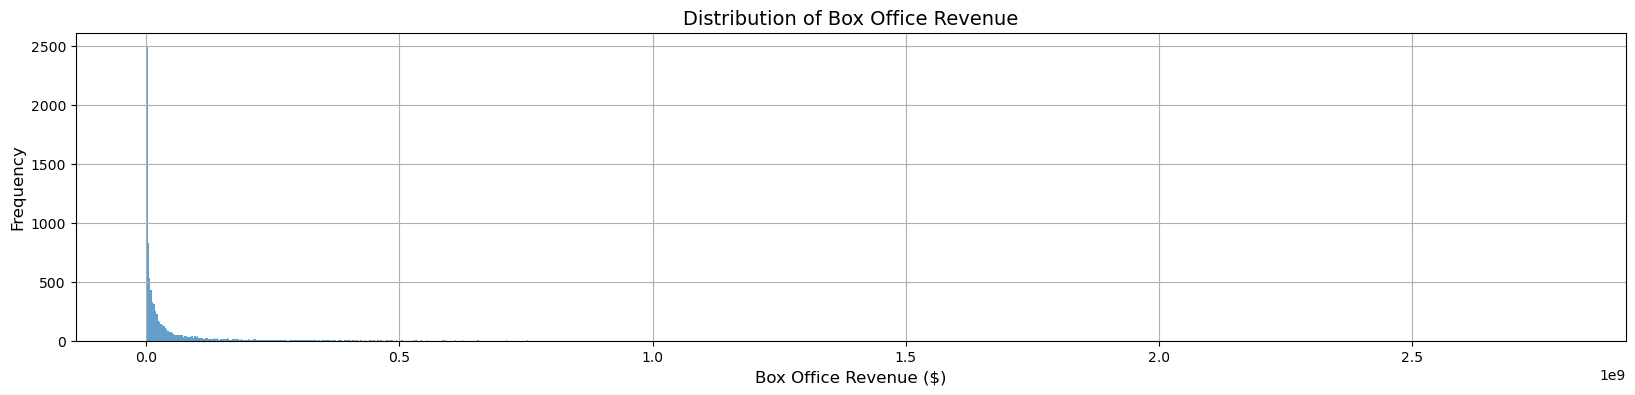

In [58]:
plt.figure(figsize=(20, 4))
plt.hist(movies['Movie box office revenue'], bins=1000, alpha=0.7)
plt.title('Distribution of Box Office Revenue', fontsize=14)
plt.xlabel('Box Office Revenue ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()


# Runtime

### Scatter plot

The graph shows us that runtime of 80 - 140 minutes are very consistently scoring a budget from 0 - 200 million with some outliers. Movies with a runtime shorter than 80 minutes don't have many big hits, telling us that short films are not the way to go. If you go with a runtime longer than 140 minutes then you start to get into big box office territory.

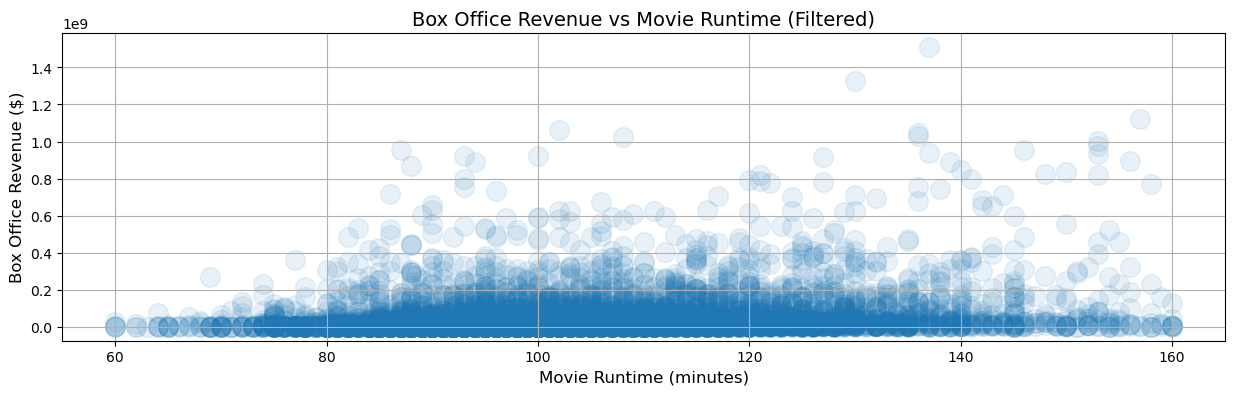

In [59]:
# Filter out movies with runtime > 300 minutes and revenue > 1e9
filtered_movies = movies[(movies['Movie runtime'] <= 160) &
                                 (movies['Movie runtime'] >= 60)]

plt.figure(figsize=(15, 4))
plt.scatter(filtered_movies['Movie runtime'], filtered_movies['Movie box office revenue'], alpha=0.1, s=200)
plt.title('Box Office Revenue vs Movie Runtime (Filtered)', fontsize=14)
plt.xlabel('Movie Runtime (minutes)', fontsize=12)
plt.ylabel('Box Office Revenue ($)', fontsize=12)
plt.grid(True)
plt.show()


# Genre

### Genre vs Box Office Revenue (Bar Plot)

### Using CMU dataset

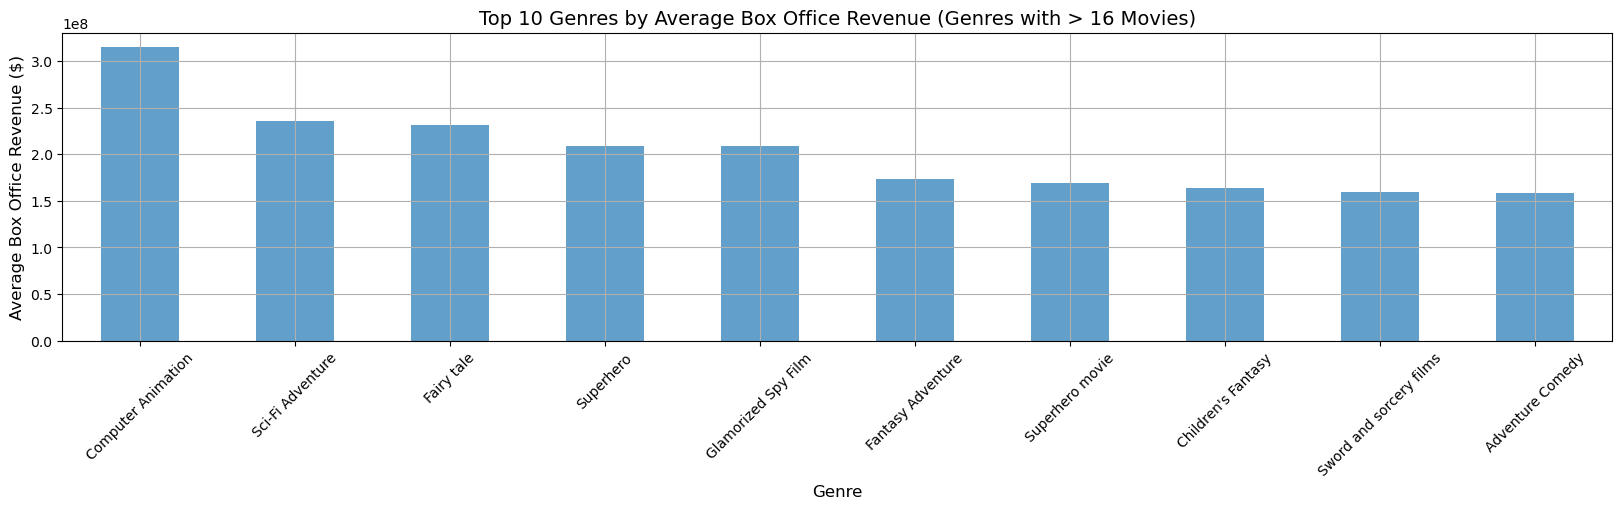

In [67]:
movies_with_genres = movies.explode('Extracted Genres')

genre_revenue = movies_with_genres.groupby('Extracted Genres')['Movie box office revenue'].mean().sort_values(ascending=False)

LIMIT_SAMPLE = 15
genre_counts = movies_with_genres['Extracted Genres'].value_counts()
valid_genres = genre_counts[genre_counts >= LIMIT_SAMPLE].index  

movies_with_valid_genres = movies_with_genres[movies_with_genres['Extracted Genres'].isin(valid_genres)]

genre_revenue = movies_with_valid_genres.groupby('Extracted Genres')['Movie box office revenue'].mean().sort_values(ascending=False)

plt.figure(figsize=(20, 4))
genre_revenue.head(10).plot(kind='bar', alpha=0.7)
plt.title(f'Top 10 Genres by Average Box Office Revenue (Genres with > {LIMIT_SAMPLE+1} Movies)', fontsize=14)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Average Box Office Revenue ($)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()



We can see that the top three movies are Computer Animation, Sci-Fi and Fairy Tale.

In spot number two we have computer animation, this genre is so high up because of it's target audience. Which is every single kid, most teenagers, and young people. These are the people who are most likey to buy a ticket to the movies. Not to mention that for every kid at least one parent will follow.

Of note:
With a sample size at 7 we get that reboots are the biggest success at over 4 billion revenue average, but we also get Nature in number 3 only because Avatar is included.
Let's look at reboots and why it's at the top. Ever since people started consuming movies and tv via internet the DVD sales have plummeted, resulting in the income for producers to drop. Before the income came from theater ticket sales and then DVD sales later on. Since the DVD sales are no more the studios are at a bigger risk at losing money. So they started to create reboots, the reason being that people know what to expect, they know they will like the movie therefore they will buy a ticket to the movies. The reboots have been a huge success and not surprising it's at number one.

### Using TMDB dataset

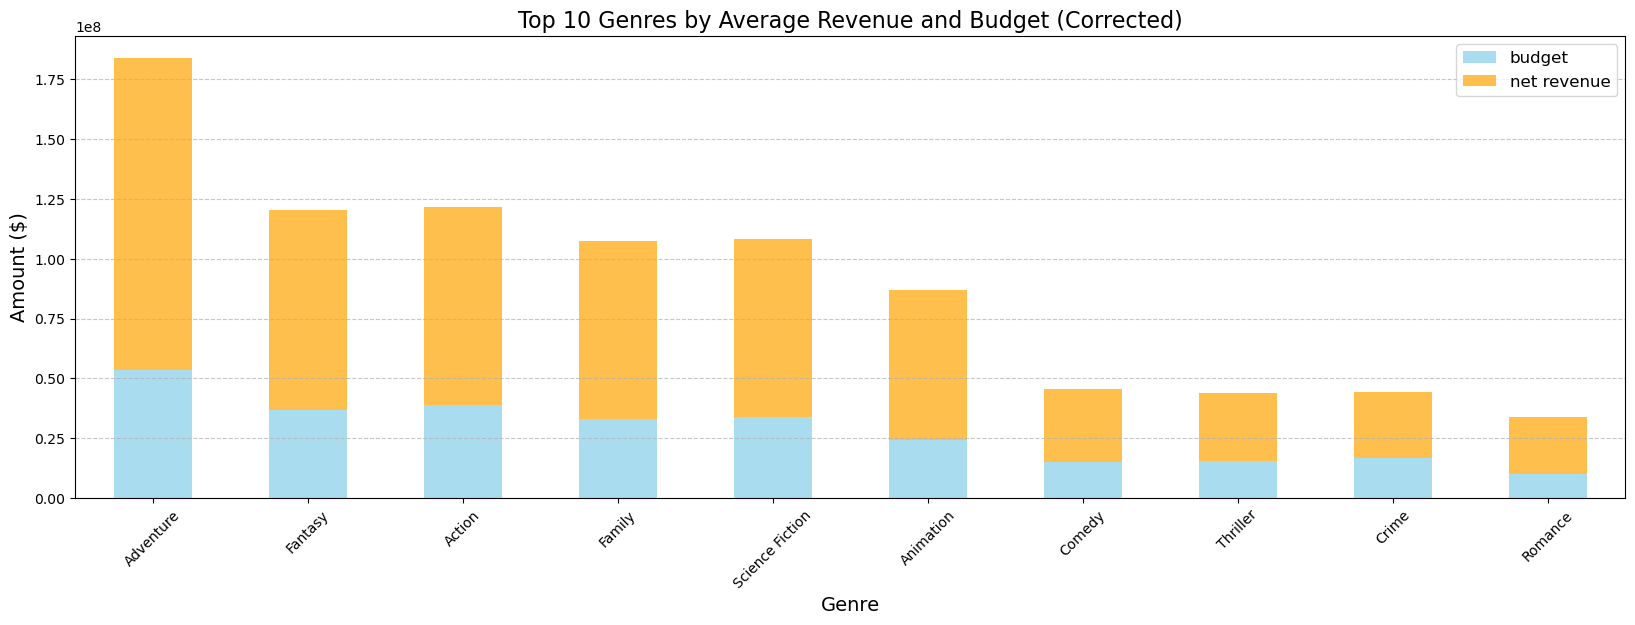

In [61]:
# Columns to show
columns = ['net revenue', 'budget']

# Drop rows with no genres, zero budget, or zero revenue
tmdb_cleaned = tmdb.dropna(subset=['Extracted Genres', columns[0], columns[1]])

# Explode genres into separate rows
tmdb_exploded = tmdb_cleaned.explode('Extracted Genres')

# Group by genre and calculate average budget and net revenue
genre_stats = tmdb_exploded.groupby('Extracted Genres')[[columns[0], columns[1]]].mean().sort_values(by=columns[0], ascending=False)

# Plot the top 10 genres with a stacked bar chart
top_genres = genre_stats.head(10)

# Adjust the stacked bar
fig, ax = plt.subplots(figsize=(20, 6))
top_genres[columns[1]].plot(kind='bar', color='skyblue', ax=ax, label=columns[1], alpha=0.7)
top_genres[columns[0]].plot(kind='bar', color='orange', ax=ax, bottom=top_genres[columns[1]], label=columns[0], alpha=0.7)

# Customize the plot
plt.title('Top 10 Genres by Average Revenue and Budget (Corrected)', fontsize=16)
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Amount ($)', fontsize=14)
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


The data from the TMDB is a lot more representative when it comes to genre vs box office. 
We can see that adventure is at the top with 746 movies and the top 5 are:
- Avatar
- Avangers: End Game
- Avatar: The Way of Water
- Star Wars: The Force Awakens
- Avengers: Infinity War

### Archive

Using TMDB database but looking at net revenue.

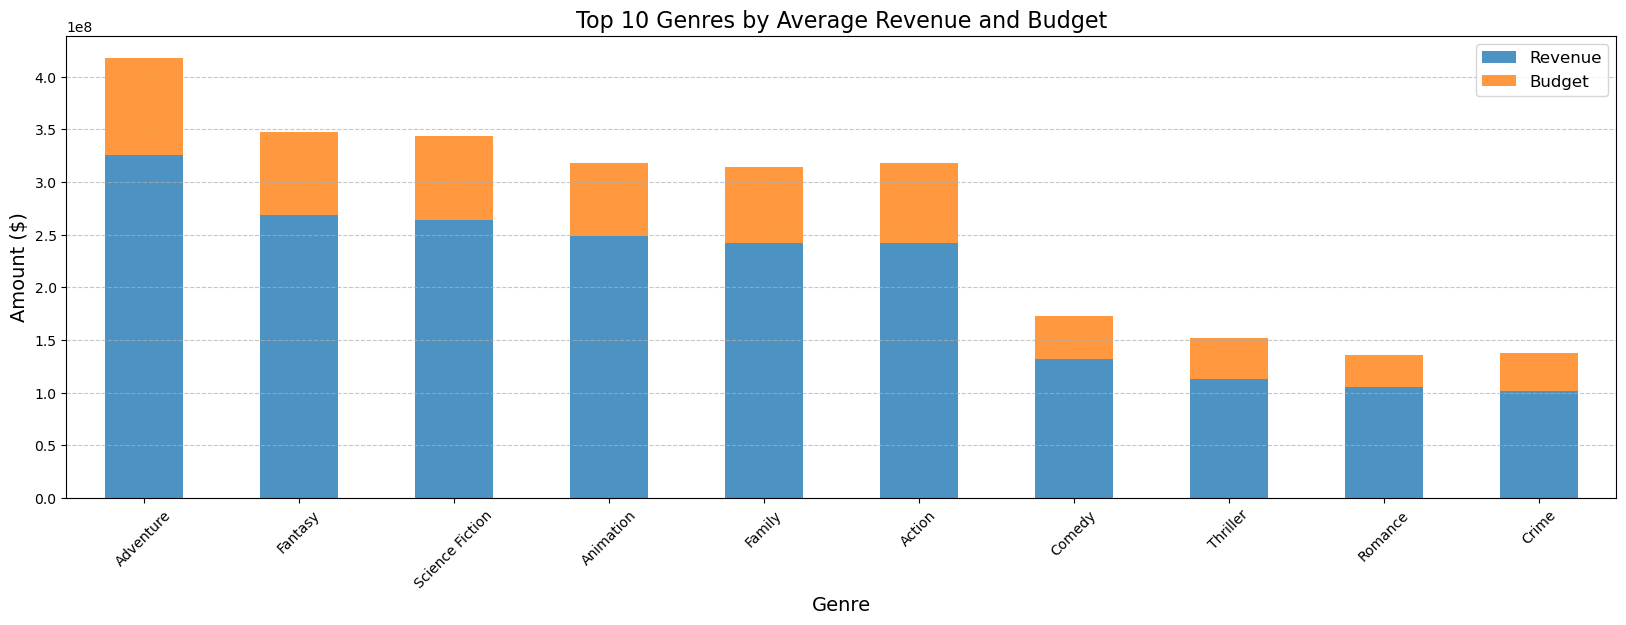

In [62]:
# Drop rows with no genres, zero budget, or zero revenue
tmdb_cleaned = tmdb.dropna(subset=['Extracted Genres', 'revenue', 'budget'])
tmdb_cleaned = tmdb_cleaned[(tmdb_cleaned['revenue'] > 0) & (tmdb_cleaned['budget'] > 0)]

# Explode genres into separate rows
tmdb_exploded = tmdb_cleaned.explode('Extracted Genres')

# Group by genre and calculate average budget and revenue
genre_stats = tmdb_exploded.groupby('Extracted Genres')[['revenue', 'budget']].mean().sort_values(by='revenue', ascending=False)

# Plot the top 10 genres with a stacked bar chart
top_genres = genre_stats.head(10)  # Select top 10 genres by revenue
top_genres.plot(kind='bar', stacked=True, figsize=(20, 6), alpha=0.8)

# Customize the plot
plt.title('Top 10 Genres by Average Revenue and Budget', fontsize=16)
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Amount ($)', fontsize=14)
plt.xticks(rotation=45)
plt.legend(['Revenue', 'Budget'], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


C:\Users\ebben\AppData\Local\Temp\ipykernel_21796\3515670819.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_cleaned['Release Year'] = movies_cleaned['Movie release date'].dt.year


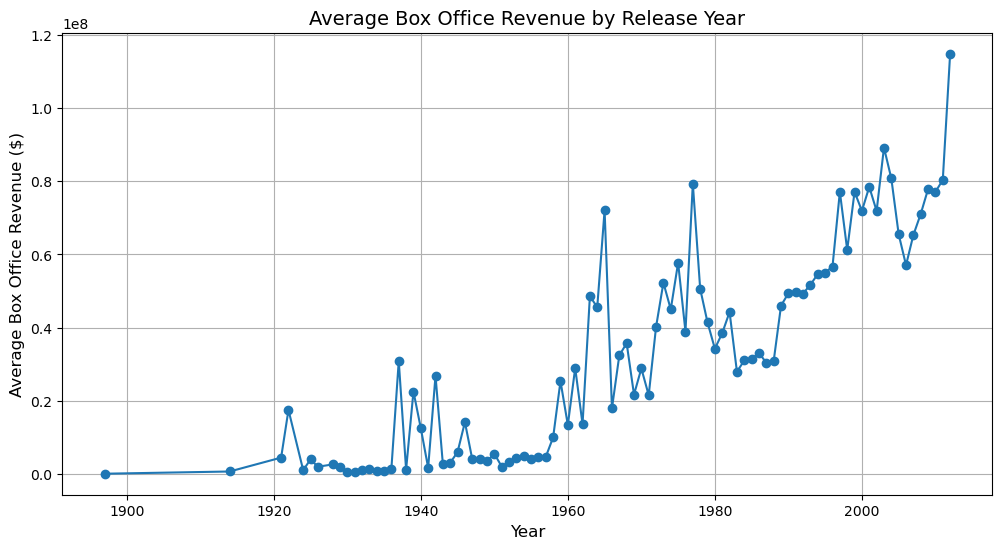

In [63]:
movies['Movie release date'] = pd.to_datetime(movies['Movie release date'], errors='coerce')
movies_cleaned = movies.dropna(subset=['Movie release date'])

# Group by year or month
movies_cleaned['Release Year'] = movies_cleaned['Movie release date'].dt.year
yearly_revenue = movies_cleaned.groupby('Release Year')['Movie box office revenue'].mean()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(yearly_revenue.index, yearly_revenue.values, marker='o')
plt.title('Average Box Office Revenue by Release Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Box Office Revenue ($)', fontsize=12)
plt.grid(True)
plt.show()


# Actor age with regression

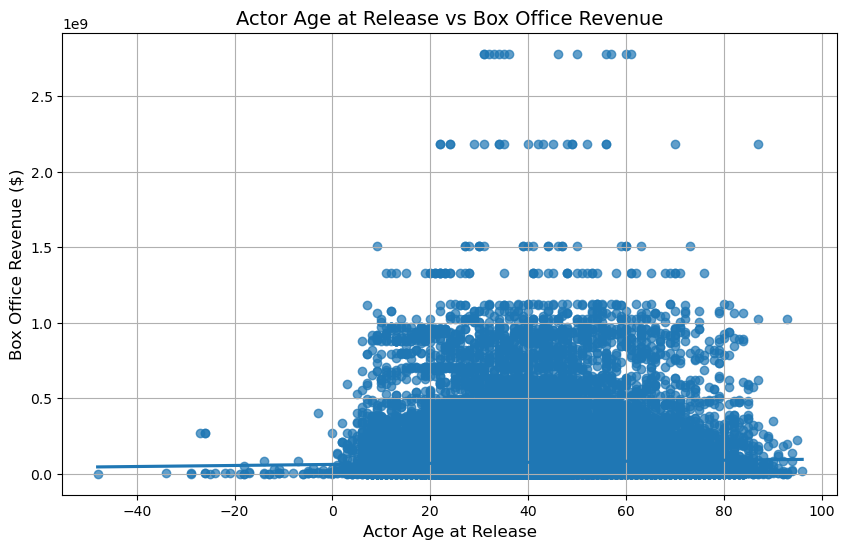

In [64]:
# Merge the two DataFrames on 'Wikipedia movie ID'
merged_df = pd.merge(characters, movies[['Wikipedia movie ID', 'Movie box office revenue']], on='Wikipedia movie ID', how='inner')

# Ensure 'Movie box office revenue' is numeric
merged_df['Movie box office revenue'] = pd.to_numeric(merged_df['Movie box office revenue'], errors='coerce')

# Drop rows with NaN values in the relevant columns
merged_df = merged_df.dropna(subset=['Actor age at movie release', 'Movie box office revenue'])

plt.figure(figsize=(10, 6))
sns.regplot(x=merged_df['Actor age at movie release'], y=merged_df['Movie box office revenue'], scatter_kws={'alpha': 0.7})
plt.title('Actor Age at Release vs Box Office Revenue', fontsize=14)
plt.xlabel('Actor Age at Release', fontsize=12)
plt.ylabel('Box Office Revenue ($)', fontsize=12)
plt.grid(True)
plt.show()


# Language vs Box Office Revenue (Bar Plot)

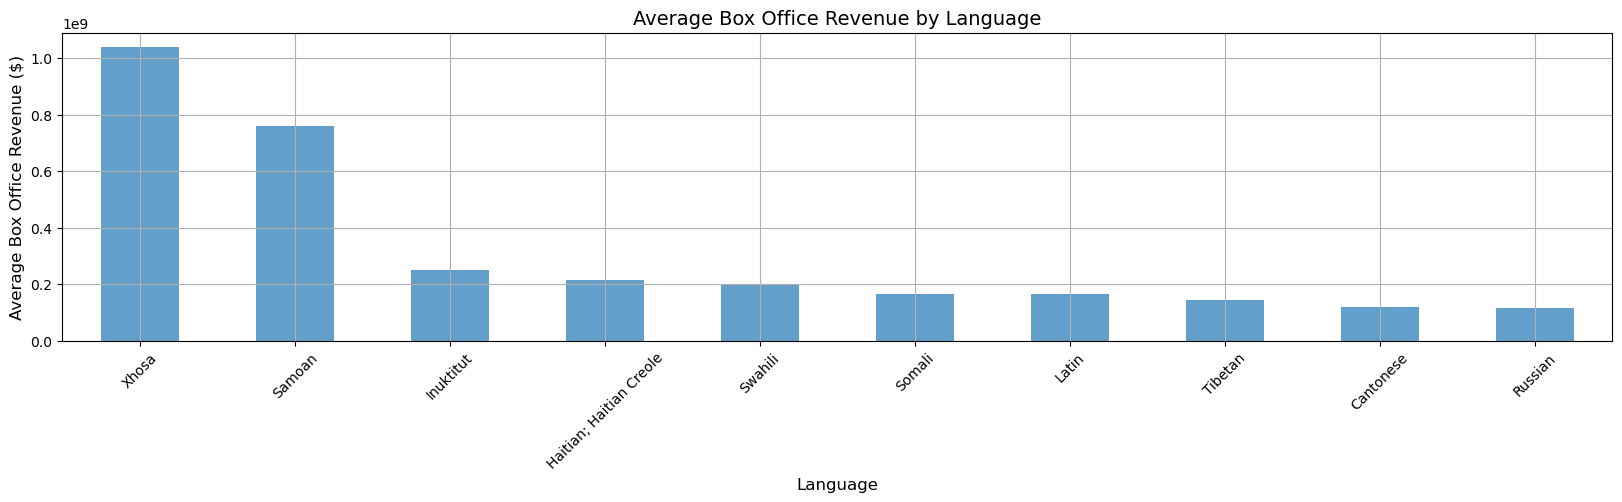

In [77]:
tmdb_lang = tmdb.explode('Extracted Languages')
tmdb_lang = tmdb_lang.dropna(subset=['Extracted Languages'])

# Group and plot
language_revenue = tmdb_lang.groupby('Extracted Languages')['revenue'].mean().sort_values(ascending=False)
plt.figure(figsize=(20, 4))
language_revenue.head(10).plot(kind='bar', alpha=0.7)
plt.title('Average Box Office Revenue by Language', fontsize=14)
plt.xlabel('Language', fontsize=12)
plt.ylabel('Average Box Office Revenue ($)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


# Trope Frequency and Box Office Revenue

In [78]:
# Process trope data
tvtropes['Movie box office revenue'] = tvtropes['Info'].apply(lambda x: x.get('Movie box office revenue', None))
tvtropes = tvtropes.dropna(subset=['Movie box office revenue'])

# Group and plot
trope_revenue = tvtropes.groupby('Trope')['Movie box office revenue'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
trope_revenue.head(10).plot(kind='bar', alpha=0.7)
plt.title('Top Tropes by Average Box Office Revenue', fontsize=14)
plt.xlabel('Trope', fontsize=12)
plt.ylabel('Average Box Office Revenue ($)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


AttributeError: 'str' object has no attribute 'get'

# Pearson/Spearman Correlation

# Multiple Regression Analysis

Linear Regression R-squared: 0.36781577938715104
Linear Regression Mean Squared Error: 41.86893604596666
Random Forest R-squared: 0.6133170283816063
Random Forest Mean Squared Error: 25.60963099183341
Feature Importances (Random Forest):
                      Feature  Importance
3  Runtime_Budget_Interaction    0.617700
2                  popularity    0.242873
0                     runtime    0.089876
1                      budget    0.049551


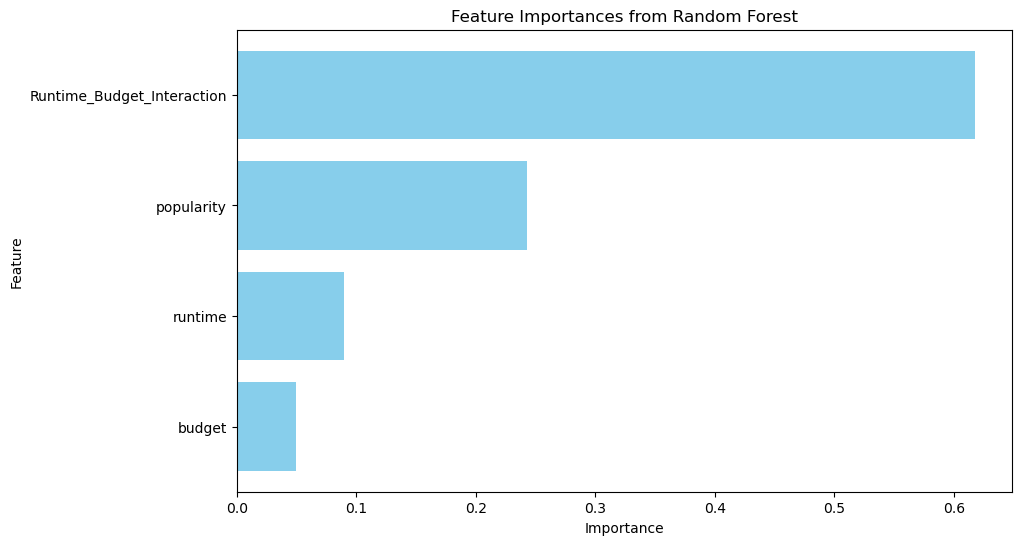

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from ast import literal_eval

# Helper functions for processing JSON-like columns
def str_to_list(entry):
    try:
        return [d['name'] for d in literal_eval(entry)]
    except:
        return []

# Load TMDB Data
PATH = 'cmu/'
tmdb = pd.read_csv(PATH + 'TMDB.csv')
tmdb.columns = [col.strip() for col in tmdb.columns]  # Clean up column names

# Process and Clean TMDB Data
tmdb['genres_list'] = tmdb['genres'].apply(str_to_list)
tmdb['languages_list'] = tmdb['spoken_languages'].apply(str_to_list)

# Convert relevant columns to numeric
tmdb['revenue'] = pd.to_numeric(tmdb['revenue'], errors='coerce')
tmdb['budget'] = pd.to_numeric(tmdb['budget'], errors='coerce')
tmdb['runtime'] = pd.to_numeric(tmdb['runtime'], errors='coerce')
tmdb = tmdb.dropna(subset=['revenue', 'budget', 'runtime', 'genres_list'])

# Log-transform revenue
tmdb['log_revenue'] = np.log1p(tmdb['revenue'])

# One-Hot Encoding for Top Genres and Languages
from collections import Counter

# Extract most common genres
genre_counter = Counter([genre for sublist in tmdb['genres_list'] for genre in sublist])
top_genres = [genre for genre, count in genre_counter.most_common(10)]
for genre in top_genres:
    tmdb[f'Genre_{genre}'] = tmdb['genres_list'].apply(lambda x: 1 if genre in x else 0)

# Extract most common languages
lang_counter = Counter([lang for sublist in tmdb['languages_list'] for lang in sublist])
top_languages = [lang for lang, count in lang_counter.most_common(5)]
for lang in top_languages:
    tmdb[f'Lang_{lang}'] = tmdb['languages_list'].apply(lambda x: 1 if lang in x else 0)

# Add Interaction Term
tmdb['Runtime_Budget_Interaction'] = tmdb['runtime'] * tmdb['budget']

# Prepare Data for Modeling
features = ['runtime', 'budget', 'popularity', 'Runtime_Budget_Interaction'] + [f'Genre_{genre}' for genre in top_genres] + [f'Lang_{lang}' for lang in top_languages]
X = tmdb[features]
y = tmdb['log_revenue']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression Model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
r2_lr = r2_score(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)

print("Linear Regression R-squared:", r2_lr)
print("Linear Regression Mean Squared Error:", mse_lr)

# Random Forest Model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)

print("Random Forest R-squared:", r2_rf)
print("Random Forest Mean Squared Error:", mse_rf)

# Feature Importance for Random Forest
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances (Random Forest):")
print(feature_importances)

# Plot Feature Importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.show()
